In [1]:
%%capture
!pip install skimpy
!pip install scikit-learn==1.1.3
!pip install imblearn

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

from skimpy import clean_columns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import numpy as np
from collections import Counter

RANDOM_STATE = 12345

## Обзор данных

In [3]:
# Открываем файл с данными
file_path = '/datasets/Churn.csv'
df = pd.read_csv(file_path)

# Изучаем первые несколько строк данных
print("Первые несколько строк данных:")
display(df.head())

# Выводим общую информацию о данных
print("\nОбщая информация о данных:")
df.info()

# Описательная статистика по данным
print("\nОписательная статистика данных:")
display(df.describe().T)

# Проверка на наличие пропущенных значений
missing_values_count = df.isnull().sum()
print("\nКоличество пропущенных значений в в каждом столбце:")
print(missing_values_count)

# Проверка на наличие дубликатов
duplicate_count = df.duplicated().sum()
print("\nКоличество дубликатов в данных:", duplicate_count)

Первые несколько строк данных:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Описательная статистика данных:


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48



Количество пропущенных значений в в каждом столбце:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Количество дубликатов в данных: 0


**Вывод:**

Описание признаков:

1. **RowNumber** — индекс строки в данных. Это технический признак и не имеет значения для анализа.
2. **CustomerId** — уникальный идентификатор клиента. Уникальный идентификатор, который также не нужен для моделирования.
3. **Surname** — фамилия клиента. Этот признак не имеет значения для предсказания и может быть исключен из анализа.
4. **CreditScore** — кредитный рейтинг клиента. Важный финансовый показатель, который влияет на вероятность ухода клиента.
5. **Geography** — страна проживания клиента. Категориальный признак, который может быть важным для анализа.
6. **Gender** — пол клиента. Категориальный признак, который может влиять на поведение клиента.
7. **Age** — возраст клиента. Возраст может быть значимым фактором в предсказании ухода клиента.
8. **Tenure** — сколько лет человек является клиентом банка. Длительность обслуживания в банке может влиять на вероятность ухода.
9. **Balance** — баланс на счёте клиента. Финансовый показатель, который может быть важен для анализа.
10. **NumOfProducts** — количество продуктов банка, используемых клиентом. Может влиять на уровень удовлетворенности клиента.
11. **HasCrCard** — наличие кредитной карты у клиента. Бинарный признак, который может влиять на уход клиента.
12. **IsActiveMember** — активность клиента. Важный признак для определения вероятности ухода.
13. **EstimatedSalary** — предполагаемая зарплата клиента. Финансовый показатель, который может быть значимым для анализа.

Целевой признак:

- **Exited** — факт ухода клиента. Целевой признак, который мы будем предсказывать.

Статистические данные:

- **Размер набора данных**: 10000 записей.
- **Пропуски в данных**: Колонка `Tenure` имеет 909 пропущенных значений.

Общая информация:

- **CreditScore** варьируется от 350 до 850.
- **Возраст** клиентов варьируется от 18 до 92 лет.
- **Tenure** варьируется от 0 до 10 лет.
- **Balance** варьируется от 0 до 250898.09.
- **NumOfProducts** варьируется от 1 до 4.
- **EstimatedSalary** варьируется от 11.58 до 199992.48.
- **Exited**: 20.37% клиентов ушли.

Для дальнейшего анализа мы:

1. Исключим из анализа технические признаки (RowNumber, CustomerId, Surname).
2. Приведём колонки к змеиному регистру.
3. Заполним пропуски в колонке `Tenure` медианным значением

### Предобработка данных

In [4]:
# Удалим неважные для дальнейшего анализа столбцы
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [5]:
# Приведём колонки к змеиному регистру
df = clean_columns(df)

# Посмотрим на новые названия столбцов
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [6]:
# Процент пропусков в столбце tenure
missing_ratio = df['tenure'].isnull().mean() * 100
print(f"Процент пропусков в столбце Tenure: {missing_ratio:.2f}%")

Процент пропусков в столбце Tenure: 9.09%


Возможно, пропуски в столбце **tenure** могут быть связаны с ошибкой при сборе данных, поэтому будем следовать принципу, что следующие данные будут такими же по распределению, как текущие, и лучшей тактикой минимизации ошибки будет значение из области наибольшей плотности распределения, не изменяющую структуры распределения признака.

Доля пропусков не критично велика, возможно и решение с удалением. Однако данных у нас не много, я остановлюсь на заполнении пропусков медианным значением.

In [7]:
# Заполним пропуски медианным значением
df['tenure'] = df['tenure'].fillna(df['tenure'].median())

# Проверка
print("Количество пропусков после заполнения:", df['tenure'].isnull().sum())

Количество пропусков после заполнения: 0


In [8]:
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)

**Вывод:**

Удалены столбцы 'RowNumber', 'CustomerId' и 'Surname' с помощью метода drop(), так как они не представляют ценности для задачи классификации и не несут информации о поведении клиентов.

Имена столбцов были приведены к нижнему регистру и добавлены пробелы между словами, чтобы сделать названия более читаемыми. Это было сделано с помощью функции clean_columns из библиотеки skimpy.

Далее было проанализировано наличие пропущенных значений в столбце 'Tenure', который показал 9.09% пропусков. Пропуски были заполнены медианным значением.

## Исследование баланса классов и обучение модели без учёта дисбаланса

In [9]:
# Проверка баланса классов
class_balance = df['exited'].value_counts(normalize=True) 
print(class_balance)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Баланс классов в данных:

Класс 0 (клиенты, которые не ушли): 79.63%  
Класс 1 (клиенты, которые ушли): 20.37%  

In [10]:
# Разделение данных на признаки и целевой признак
X = df.drop('exited', axis=1)
y = df['exited']

# Разделение на обучающую, валидационную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

# Списки признаков для обработки
numeric_features = ['balance', 'estimated_salary', 'credit_score', 'age', 'tenure']

# Масштабируем числовые признаки
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_valid[numeric_features] = scaler.transform(X_valid[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Вычисляем размеры исходного датасета и выборок
total_samples = len(df)
train_samples = len(X_train)
valid_samples = len(X_valid)
test_samples = len(X_test)

# Вычисляем проценты от исходного датасета
train_percent = (train_samples / total_samples) * 100
valid_percent = (valid_samples / total_samples) * 100
test_percent = (test_samples / total_samples) * 100

# Выводим информацию о размерах выборок
print(f"Размер исходного датасета: {total_samples}")
print(f"Размер обучающей выборки: {train_samples} ({train_percent:.2f}%)")
print(f"Размер валидационной выборки: {valid_samples} ({valid_percent:.2f}%)")
print(f"Размер тестовой выборки: {test_samples} ({test_percent:.2f}%)")

Размер исходного датасета: 10000
Размер обучающей выборки: 6000 (60.00%)
Размер валидационной выборки: 2000 (20.00%)
Размер тестовой выборки: 2000 (20.00%)


Теперь готовы для обучения модели.

In [11]:
# Инициализируем модели
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [12]:
# Словарь параметров для каждой модели
param_grid = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
    },
    'Random Forest': {
        'n_estimators': [25, 50, 100],
        'max_depth': [5, 15, 25],
        'min_samples_split': [2, 5, 10],
    },
    'Gradient Boosting': {
        'n_estimators': [25, 50, 100],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    }
}

In [13]:
# Инициализируем модели
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [14]:
# Подбор лучших параметров и оценка качества моделей
for model_name, model in models.items():
    print(f"Модель: {model_name}")
    
    # Поиск лучших параметров с использованием F1 в качестве целевой метрики
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    # Лучшие параметры и оценка на валидационной выборке
    best_params = grid_search.best_params_
    print(f"Лучшие параметры:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    # Лучшая модель с лучшими параметрами
    best_model = grid_search.best_estimator_
    
    # Предсказание на валидационной выборке
    y_pred = best_model.predict(X_valid)
    
    # Рассчитываем метрики
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    # Вывод метрик
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Предсказание вероятностей классов для расчета ROC AUC
    probabilities = best_model.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_valid, probabilities_one)
    print(f"Площадь ROC-кривой: {roc_auc:.4f}")
    
    print("--------------------------------------------")

Модель: Logistic Regression
Лучшие параметры:
C: 10
Precision: 0.5745
Recall: 0.2072
F1-score: 0.3045
Площадь ROC-кривой: 0.7703
--------------------------------------------
Модель: Decision Tree
Лучшие параметры:
max_depth: 10
min_samples_split: 10
Precision: 0.6221
Recall: 0.4885
F1-score: 0.5473
Площадь ROC-кривой: 0.7678
--------------------------------------------
Модель: Random Forest
Лучшие параметры:
max_depth: 25
min_samples_split: 10
n_estimators: 50
Precision: 0.7623
Recall: 0.4348
F1-score: 0.5537
Площадь ROC-кривой: 0.8474
--------------------------------------------
Модель: Gradient Boosting
Лучшие параметры:
learning_rate: 0.1
max_depth: 3
n_estimators: 100
Precision: 0.7173
Recall: 0.4348
F1-score: 0.5414
Площадь ROC-кривой: 0.8591
--------------------------------------------


**Вывод:**

1. **Баланс классов**:
   - Данные сильно несбалансированы: 79.63% записей относятся к классу 0 и только 20.37% к классу 1.

2. **Производительность моделей без учёта дисбаланса**:
   - Модель логистической регрессии показала низкое значение F1-score (0.3045) из-за низкого recall (0.2072). Это свидетельствует о том, что модель плохо справляется с идентификацией положительных случаев.
   - Дерево решений и случайный лес показали более высокие значения F1-score (0.5473 и 0.5537 соответственно), что делает их более эффективными в данной задаче.
   - Градиентный бустинг показал самую высокую площадь под ROC-кривой (0.8591), что указывает на его лучшую общую производительность, несмотря на F1-score 0.5414.

3. **Лучшая модель**:
   - С учетом как F1-score, так и ROC AUC, модель случайного леса является наилучшей в данной задаче.
   - Она показывает хороший баланс между precision и recall, а также высокое значение ROC AUC, что свидетельствует о её общей эффективности.

## Обучение модели с учётом дисбаланса

**Oversample и Undersample**

In [15]:
# Методы балансировки
sampling_methods = {
    'oversample': SMOTE(random_state=RANDOM_STATE),
    'undersample': RandomUnderSampler(random_state=RANDOM_STATE)
}

In [16]:
# Для сохранения лучших моделей
best_models = {'oversample': {}, 'undersample': {}}

# Подбор лучших параметров и оценка качества моделей для каждого метода балансировки
results = {'oversample': [], 'undersample': []}

for sampling_name, sampler in sampling_methods.items():
    # Применение метода балансировки
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    class_distribution = y_resampled.value_counts(normalize=True)
    
    for model_name, model in models.items():
        # Поиск лучших параметров с использованием F1 в качестве целевой метрики
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, scoring='f1')
        grid_search.fit(X_resampled, y_resampled)
        
        # Лучшие параметры и оценка на валидационной выборке
        best_params = grid_search.best_params_
        
        # Лучшая модель с лучшими параметрами
        best_model = grid_search.best_estimator_
        
        # Предсказание на валидационной выборке
        y_pred = best_model.predict(X_valid)
        
        # Рассчитываем метрики
        precision = precision_score(y_valid, y_pred)
        recall = recall_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        
        # Предсказание вероятностей классов для расчета ROC AUC
        probabilities = best_model.predict_proba(X_valid)
        probabilities_one = probabilities[:, 1]
        roc_auc = roc_auc_score(y_valid, probabilities_one)
        
        # Сохранение результатов
        results[sampling_name].append({
            'Model': model_name,
            'Best Params': best_params,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'ROC AUC': roc_auc
        })
        
        # Сохранение лучшей модели
        best_models[sampling_name][model_name] = best_model

# Вывод результатов в виде таблиц с расширенными столбцами
pd.set_option('display.max_colwidth', None)
for sampling_name, sampling_results in results.items():
    print(f"\nРезультаты для метода балансировки: {sampling_name.capitalize()}\n")
    df_results = pd.DataFrame(sampling_results)
    display(df_results)


Результаты для метода балансировки: Oversample



,Model,Best Params,Precision,Recall,F1-score,ROC AUC
0,Logistic Regression,{'C': 0.1},0.369276,0.639386,0.468165,0.765218
1,Decision Tree,"{'max_depth': 15, 'min_samples_split': 2}",0.436255,0.560102,0.490482,0.704454
2,Random Forest,"{'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}",0.580645,0.598465,0.589421,0.842390
3,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}",0.591304,0.521739,0.554348,0.841179



Результаты для метода балансировки: Undersample



,Model,Best Params,Precision,Recall,F1-score,ROC AUC
0,Logistic Regression,{'C': 0.01},0.367263,0.682864,0.477639,0.770624
1,Decision Tree,"{'max_depth': 5, 'min_samples_split': 5}",0.396907,0.787724,0.527849,0.809903
2,Random Forest,"{'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 50}",0.443411,0.731458,0.552124,0.844594
3,Gradient Boosting,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}",0.455538,0.746803,0.565891,0.845308


**Вывод:**

На основе F1-score наилучшие результаты показала модель **Random Forest** при использовании oversample с параметрами:
- `max_depth`: 25
- `min_samples_split`: 2
- `n_estimators`: 100

Эта модель показала F1-score = 0.589421 и ROC AUC = 0.842390.

## Проверка лучшей модели на тестовой выборке

In [18]:
# Проверка лучшей модели на тестовой выборке
best_model_params = {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}

# Обучение лучшей модели Random Forest с использованием SMOTE
sampler = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

best_model_rf = RandomForestClassifier(random_state=RANDOM_STATE, **best_model_params)
best_model_rf.fit(X_resampled, y_resampled)

# Оценка модели на тестовой выборке
y_test_pred = best_model_rf.predict(X_test)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, best_model_rf.predict_proba(X_test)[:, 1])
и

Метрики для Random Forest на тестовой выборке:
Precision: 0.6188
Recall: 0.6159
F1-score: 0.6174
Площадь ROC-кривой: 0.8494


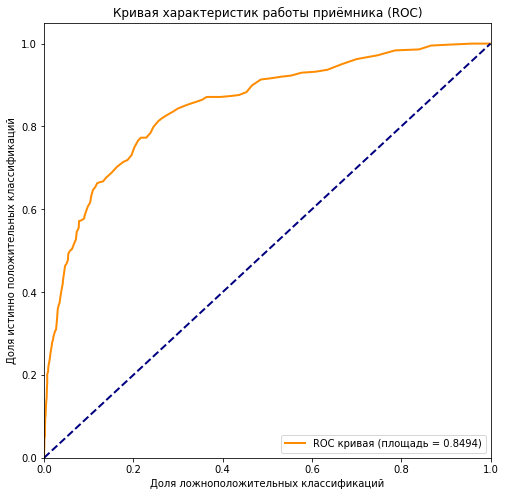

In [30]:
# Построение графика
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (площадь = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных классификаций')
plt.ylabel('Доля истинно положительных классификаций')
plt.title('Кривая характеристик работы приёмника (ROC)')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Обучение Dummy модели, которая предсказывает только класс '1'
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train, y_train)

# Предсказание и оценка Dummy модели на тестовой выборке
y_test_dummy_pred = dummy_model.predict(X_test)
precision_dummy = precision_score(y_test, y_test_dummy_pred)
recall_dummy = recall_score(y_test, y_test_dummy_pred)
f1_dummy = f1_score(y_test, y_test_dummy_pred)

# Вывод метрик Dummy модели на тестовой выборке
print(f"Метрики для Dummy модели на тестовой выборке:")
print(f"Precision: {precision_dummy:.4f}")
print(f"Recall: {recall_dummy:.4f}")
print(f"F1-score: {f1_dummy:.4f}")

# Сравнение с моделью Random Forest
print(f"\nСравнение моделей на тестовой выборке:")
print(f"Random Forest - F1-score: {f1_test:.4f}, Recall: {recall_test:.4f}")
print(f"Dummy модель - F1-score: {f1_dummy:.4f}, Recall: {recall_dummy:.4f}")

# Анализ результатов
if f1_test > f1_dummy:
    print("\nМодель Random Forest превосходит Dummy модель по F1-мере.")
else:
    print("\nМодель Random Forest не превосходит Dummy модель по F1-мере.")

# Вывод на основе recall
print(f"\nДоля верно детектированных клиентов на отток моделью Random Forest: {recall_test:.4f}")
print(f"Доля верно детектированных клиентов на отток Dummy моделью: {recall_dummy:.4f}")

Метрики для Dummy модели на тестовой выборке:
Precision: 0.2135
Recall: 1.0000
F1-score: 0.3519

Сравнение моделей на тестовой выборке:
Random Forest - F1-score: 0.6174, Recall: 0.6159
Dummy модель - F1-score: 0.3519, Recall: 1.0000

Модель Random Forest превосходит Dummy модель по F1-мере.

Доля верно детектированных клиентов на отток моделью Random Forest: 0.6159
Доля верно детектированных клиентов на отток Dummy моделью: 1.0000


**Вывод:**

Модель Random Forest превосходит Dummy модель по F1-мере, что указывает на ее более высокую общую производительность в распознавании клиентов, склонных к оттоку, при учете баланса между точностью и полнотой. Наша модель корректно идентифицирует около 61.59% клиентов, склонных к оттоку, что достаточно хорошо для большинства практических задач. Dummy модель, предсказывающая всех клиентов как склонных к оттоку, имеет Recall 100%, но ее низкая Precision и F1-score показывают, что она не является практически полезной, так как она не дифференцирует клиентов, действительно склонных к оттоку, от тех, кто остается.

ROC-кривая (Receiver Operating Characteristic curve) на предоставленном графике показывает, что модель имеет AUC-ROC (площадь под кривой) = 0.8494, что также является хорошим показателем. Высокое значение AUC-ROC свидетельствует о том, что модель хорошо различает классы.

По заданию требовалось довести метрику F1 до 0.59, результат нашей модели - 0.6174.